## Illustrate light curve seasons

### Necessary imports

In [2]:
import pandas as pd
pd.options.display.max_columns = 999
from itertools import product
import numpy as np
import os 
import sys
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
import pandas as pd
from scipy.stats import binned_statistic_2d
from astropy.table import Table
from astropy.table import vstack
from astropy.table import Column

import datetime

import matplotlib.pyplot as plt
from matplotlib import rcParams      
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 20

### Read in a few  light curves ...

In [13]:
# Photometry in each small square patch was saved to  
#  /rawDataFP/

# When it was  sorted according to objID, the result was saved to 
#  /rawDataFPSplit/ 
#  g176_181  means   g filter,  from patch 176 to 181.  

# easier to read with Pandas because I can limit nrows...
DirIn = '../raw_data/rawDataFPSplit/'
fp = pd.read_csv(DirIn + 'g00_21.csv.gz', nrows=2000)

# then convert to AstroPy Table because it's much easier to handle ....
fp_table = Table.from_pandas(fp)

In [14]:
objects = np.unique(fp_table['objectId'].data)
mask = fp_table['objectId'].data == objects[0]
# choose that one object data 
fp_object = fp_table[mask]

In [15]:
# meaning forced photometry for an object...
fp_object

id,objectId,exposure_id,mjd,psfFlux,psfFluxErr
int64,int64,int64,float64,float64,float64
117783463527976604,216172782516437336,1755110376,51819.3563677,1.03803248351e-29,4.13446800369e-30
223144362022804086,216172782516437336,3325110108,52522.3177491,2.04152426121e-29,4.64365604013e-30
225493189241344494,216172782516437336,3360110361,52552.3132465,2.14556268438e-29,4.68142594621e-30
227372234614769093,216172782516437336,3388110319,52558.3215413,1.54934787718e-29,4.67848473071e-30
230459244640475912,216172782516437336,3434110353,52577.2093169,2.15435257072e-29,3.41845512626e-30
232539611304299527,216172782516437336,3465110232,52586.2125967,1.28615503495e-29,3.9066436556e-30
278173630637020086,216172782516437336,4145110110,52910.2931717,1.48143367624e-29,2.95176018477e-30
281327763753802251,216172782516437336,4192110356,52931.2234663,2.44926303249e-29,4.55722491851e-30
282065964546136376,216172782516437336,4203110405,52935.220414,1.09313411102e-29,3.37328795527e-30


### Calculate seasonal averages ... 

In [16]:
# Use the code from processPatch2.py 

# 2.1 :  make a new column to designate seasons...
fp_object['season'] = np.nan

In [21]:
from astropy.time import Time
# I make a list of boundaries between season start / end : 
# season_bounds
# first it's a list with 2005-08-01 , 2006-08-01, etc...
season_bounds = [str(year)+'-08-01 00:00:00.000' for year in 
                                           np.arange(2005,2009)]
# Then I insert a very early date at the beginning of the list, 
season_bounds.insert(0,'1990-08-01 00:00:00.000' )
# so that all epochs between
# 1990 and 2005 are clustered together.
# Thus 1990-08-01 - 2005-08-01  is Season1
# 2005-2006  : Season2 ;  2006-2007 : Season3, etc.  
# raw photometry is averaged here WITHIN each Season. 

# Use AstroPy Time module
cutDates = Time(season_bounds, format='iso')
seasons = np.arange(len(cutDates))+0 

# Assign value of a season for each row...
for i in range(len(cutDates.mjd)-1):
    mask = (fp_object['mjd'].data > cutDates[i].mjd) * \
           (fp_object['mjd'].data < cutDates[i+1].mjd)
    fp_object['season'][mask]  = seasons[i]  
# this is better than raw_data[mask]['season'] : 
# somehow the order  matters 


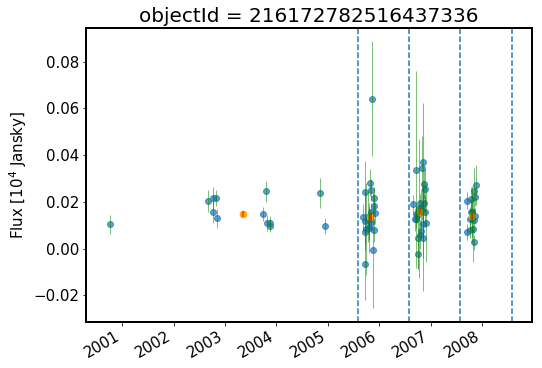

In [134]:
# Use the variability functions to illustrate how we calculate seasonal averages
path_to_home = '/Users/chris/GradResearch/'
sys.path.insert(0, path_to_home + 'SDSS_S82_FP_research/packages/')
import variabilityFunctions as varF

# Illustrate the seasons, and plot seasonal mean and median ...
fp_time = Time(fp_object['mjd'].data, format='mjd')

%matplotlib inline
fig,ax = plt.subplots(1,1, figsize=(8,6))
f = 1e23*1e4
Flux,FluxErr = f*fp_object['psfFlux'],f*fp_object['psfFluxErr']
ax.scatter(fp_time.datetime, Flux, alpha=0.7)
ax.errorbar(fp_time.datetime, Flux, 
            FluxErr, linestyle='None', color='g', lw=1, alpha=0.5 )

# I mark vertically 1st of August of each year: 
# time between that is a season...    
for date in cutDates.datetime[1:]:
    ax.axvline(x = date, linestyle='--')
    
    
ax.set_ylabel('Flux '+r'$ [10^{4} \,\,\mathrm{Jansky}]$', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)   
fig.autofmt_xdate()

# Calculate seasonal averages ... 
season_avg = {'meanMJD':np.ones(4, dtype=float),
              'meanFlux':np.ones(4, dtype=float),
              'meanFluxErr':np.ones(4, dtype=float),
              'medianFlux':np.ones(4, dtype=float),
              'medianFluxErr':np.ones(4, dtype=float)
             }

for season in seasons[:-1] : 
    mask = fp_object['season'].data == season
    meanMJD = np.mean(fp_object['mjd'].data[mask])
    season_avg['meanMJD'][season] =meanMJD
    
    Flux = f*fp_object['psfFlux'][mask].data
    FluxErr =f* fp_object['psfFluxErr'][mask].data
    
    FluxWMean = varF.calcWeightedMean(Flux,FluxErr)
    FluxWMeanErr = varF.calcWeightedMeanErr(FluxErr)
    FluxMedian =  varF.calcMedian(Flux),
    FluxMedianErr = np.sqrt(np.pi / 2)*FluxWMeanErr,
    
    season_avg['meanFlux'][season] = FluxWMean
    season_avg['meanFluxErr'][season] = FluxWMeanErr
    season_avg['medianFlux'][season] = FluxMedian[0]
    season_avg['medianFluxErr'][season] = FluxMedianErr[0]
season_table = Table(season_avg)
season_mean_time = Time(season_table['meanMJD'], format='mjd')

overplot_seasonal_mean = False
if overplot_seasonal_mean :
    ax.scatter(season_mean_time.datetime, season_table['meanFlux'], alpha=0.7)
    ax.errorbar(season_mean_time.datetime, season_table['meanFlux'],
                season_table['meanFluxErr'] , linestyle='None', 
                color='red', lw=2, alpha=0.5)

overplot_seasonal_median = True
if overplot_seasonal_median :
    ax.scatter(season_mean_time.datetime, season_table['medianFlux'], 
               alpha=1, color='orange',s=43)
    ax.errorbar(season_mean_time.datetime, season_table['medianFlux'],
                season_table['medianFluxErr'] , linestyle='None', 
                color='red', lw=2, alpha=0.5)

ax.set_title('objectId = '+str(objects[0]))
plt.savefig('../data_products/Fig_illustrate_lighcurve_seasonal.png', bbox_inches='tight')

In [112]:
season_mean_time.datetime

array([datetime.datetime(2003, 5, 8, 16, 48, 13, 841944),
       datetime.datetime(2005, 10, 24, 14, 18, 39, 679163),
       datetime.datetime(2006, 10, 20, 3, 23, 10, 625169),
       datetime.datetime(2007, 10, 22, 14, 41, 13, 987104)], dtype=object)

In [107]:
FluxWMeanErr

1.2144539468491235e-30